## Initial Project - Coaligning IRIS and AIA data

### Inputs

In [26]:
import os
import numpy
import scipy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from iris_lmsalpy import extract_irisL2data as ei
from aiapy.calibrate import normalize_exposure, register, update_pointing
from astropy.io import fits

In [27]:
datapath = os.getcwd() + "/data/"
outpath = os.getcwd() + "/output/"
raster_folder = datapath + "iris_l2_20220607_202829_3620106067_raster/"
aia_folder = datapath + "iris_l2_20220607_202829_3620106067_SDO/"
raster_path = raster_folder + "iris_l2_20220607_202829_3620106067_raster_t000_r00000.fits"

### Accessing IRIS Raster Data

In [263]:
ei.info_fits(raster_path)


Filename: /Users/jkim/Desktop/mg2hk/data/iris_l2_20220607_202829_3620106067_raster/iris_l2_20220607_202829_3620106067_raster_t000_r00000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     380   ()      
  1                1 ImageHDU        33   (190, 548, 96)   int16 (rescales to float32)   
  2                1 ImageHDU        33   (125, 548, 96)   int16 (rescales to float32)   
  3                1 ImageHDU        33   (172, 548, 96)   int16 (rescales to float32)   
  4                1 ImageHDU        33   (210, 548, 96)   int16 (rescales to float32)   
  5                1 ImageHDU        33   (305, 548, 96)   int16 (rescales to float32)   
  6                1 ImageHDU        33   (60, 548, 96)   int16 (rescales to float32)   
  7                1 ImageHDU        33   (76, 548, 96)   int16 (rescales to float32)   
  8                1 ImageHDU        33   (268, 548, 96)   int16 (rescales to float32)   
  9                1 Image

In [264]:
iris_raster = ei.load(raster_path, verbose = True)
extent_hx_hy = [330.92126959698425, 426.6590563250996, -489.16880000000003, -306.8492]



The provided file is a raster IRIS Level 2 data file.

Extracting information from file /Users/jkim/Desktop/mg2hk/data/iris_l2_20220607_202829_3620106067_raster/iris_l2_20220607_202829_3620106067_raster_t000_r00000.fits... 

Available data with size Y x X x Wavelength are stored in windows labeled as:

--------------------------------------------------------------------
Index --- Window label --- Y x X x WL --- Spectral range [AA] (band)
--------------------------------------------------------------------
  0 	 C II 1336    	   548x96x190 	   1332.65 - 1337.56  (FUV)
  1 	 Fe XII 1349  	   548x96x125 	   1347.63 - 1350.85  (FUV)
  2 	 O I 1356     	   548x96x172 	   1352.20 - 1356.64  (FUV)
  3 	 Si IV 1394   	   548x96x210 	   1390.85 - 1396.16  (FUV)
  4 	 Si IV 1403   	   548x96x305 	   1398.58 - 1406.31  (FUV)
  5 	 2832         	   548x96x60 	   2831.29 - 2834.29  (NUV)
  6 	 2814         	   548x96x76 	   2812.60 - 2816.42  (NUV)
  7 	 Mg II k 2796 	   548x96x268 	   2793.05 - 

In [265]:
print(iris_raster.windows)
print(iris_raster.raster['Mg II k 2796'].data.shape)
print(iris_raster.raster['Mg II k 2796'].keys())

['Mg II k 2796']
(548, 96, 268)
dict_keys(['data', 'wl', 'date_in_filename', 'iris_obs_code', 'raster_info', 'DATE_OBS', 'DATE_END', 'TDET', 'TDESCT', 'TWAVE', 'TWMIN', 'TWMAX', 'SPCSCL', 'SPXSCL', 'SPYSCL', 'EXPTIME', 'STEPT_AV', 'POS_X', 'POS_Y', 'date_time_acq', 'date_time_acq_ok', 'number_ext', 'binxy', 'binwl', 'extent_arcsec_arcsec', 'extent_px_px', 'extent_px_arcsec', 'extent_time_px', 'extent_time_arcsec', 'extent_opt', 'extent_opt_coords', 'list_extent', 'list_extent_coords', 'temp_memmap_filename', 'temp_memmap_obj', '_raster__dim_data', 'extent_display', 'extent_display_coords', 'clip_ima', 'cmap', 'lim_yplot', 'delay', 'poi', '_raster__count_poi', '_raster__move_count_poi', '_raster__count_coords', 'xlim1', 'ylim1', 'xlim2', 'ylim2', 'xlim3', 'ylim3', 'arr_y_ax1', 'arr_x_ax1', 'arr_x_ax3', 'x_pos_ext', 'y_pos_ext', '_raster__z_pos_ori', 'z_pos_ext', 'set_IRIS', 'figsize', 'tight_layout', 'bottom', 'top', 'left', 'right', 'wspace', 'hspace', 'inc_XY', 'alt_inc_XY', 'inc_Z', 

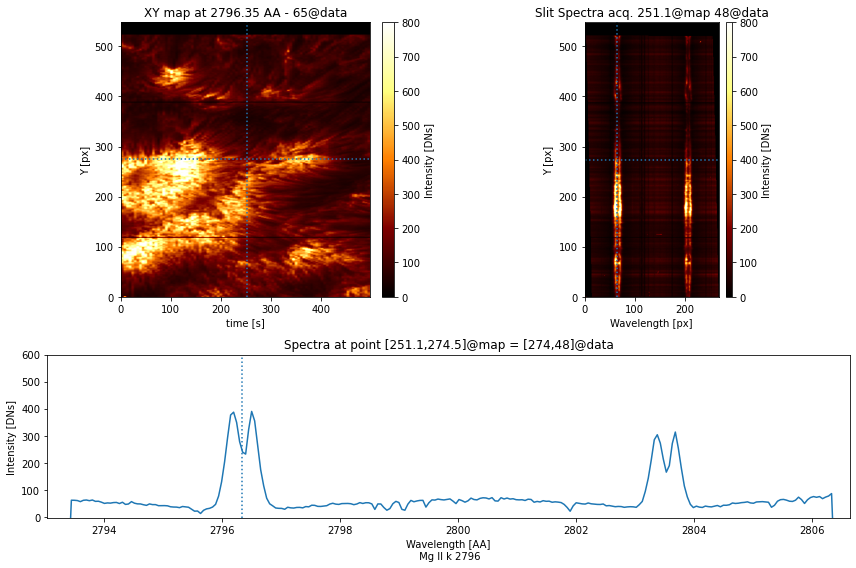

<Figure size 432x288 with 0 Axes>

In [266]:
iris_raster.quick_look()

### Accessing AIA data

In [22]:
def saveblank(fname): 
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    
    plt.savefig(outpath+fname+'.png', bbox_inches = 'tight',
        pad_inches = 0)

In [268]:
aia_paths = [x for x in os.listdir(aia_folder)]
to_examine = [3,7,8]
to_examine = [aia_paths[i] for i in to_examine]

In [269]:
img_data_list = []
header_data_list = []
for aia in to_examine:
    hdul = fits.open(aia_folder + aia)
    img_data = hdul[0].data
    header_data_list.append(hdul[0].header)
    hdul.close()
    img_data_list.append(img_data)

In [270]:
print(header_data_list[0])

SIMPLE  =                    T / Written by IDL:  Tue Jun 14 17:39:17 2022      BITPIX  =                   16 / Number of bits per data pixel                  NAXIS   =                    3 / Number of data axes                            NAXIS1  =                  608 /                                                NAXIS2  =                  471 /                                                NAXIS3  =                  568 /                                                EXTEND  =                    T / FITS data may contain extensions               DATE    = '2022-06-15'         / Creation UTC (CCCC-MM-DD) date of FITS header  COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  COMMENT and Astrophysics', volume 376, page 359; bibcode 2001A&A...376..359H    TELESCOP= '        '           /                                                INSTRUME= 'AIA_3   '           /                                                DATA_LEV=              2.00000 /        

### Visualizing AIA + IRIS

In [271]:
import sunpy.visualization.colormaps as cm
cm.sdoaia1600?

Object `cm.sdoaia1600` not found.


390.28 -398.299
(568, 471, 608)
low x: 157.87999275199996, high x: 622.680007248, low y: -589.599005615, high y: -206.99899438499997


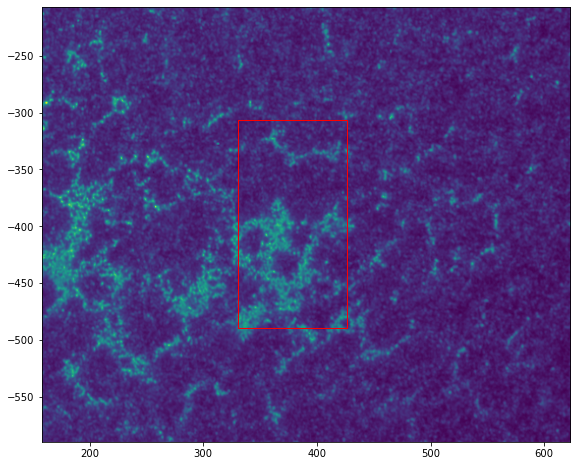

In [272]:
#1600
xcen, ycen = header_data_list[0]['XCEN'], header_data_list[0]['YCEN']
print(xcen, ycen)
dim_aia = img_data_list[0].shape
print(dim_aia)


xfov, yfov = header_data_list[0]['FOVX'], header_data_list[0]['FOVY']
low_x, high_x, low_y, high_y = xcen-xfov/2, xcen+xfov/2, ycen-yfov/2, ycen+yfov/2
print("low x: {}, high x: {}, low y: {}, high y: {}".format(low_x, high_x, low_y, high_y))

extent_aia = [low_x, high_x, low_y, high_y]
fig, ax = plt.subplots(figsize=[10,8])
ax.imshow(img_data_list[0][dim_aia[0]-1,:,:], extent=extent_aia, origin='lower')#, cmap=cm.sdoaia1600)

rect = patches.Rectangle((extent_hx_hy[0], extent_hx_hy[3]), extent_hx_hy[1]-extent_hx_hy[0], extent_hx_hy[2]-extent_hx_hy[3], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

In [273]:
iris_raster.raster['Mg II k 2796'].keys()

dict_keys(['data', 'wl', 'date_in_filename', 'iris_obs_code', 'raster_info', 'DATE_OBS', 'DATE_END', 'TDET', 'TDESCT', 'TWAVE', 'TWMIN', 'TWMAX', 'SPCSCL', 'SPXSCL', 'SPYSCL', 'EXPTIME', 'STEPT_AV', 'POS_X', 'POS_Y', 'date_time_acq', 'date_time_acq_ok', 'number_ext', 'binxy', 'binwl', 'extent_arcsec_arcsec', 'extent_px_px', 'extent_px_arcsec', 'extent_time_px', 'extent_time_arcsec', 'extent_opt', 'extent_opt_coords', 'list_extent', 'list_extent_coords', 'temp_memmap_filename', 'temp_memmap_obj', '_raster__dim_data', 'extent_display', 'extent_display_coords', 'clip_ima', 'cmap', 'lim_yplot', 'delay', 'poi', '_raster__count_poi', '_raster__move_count_poi', '_raster__count_coords', 'xlim1', 'ylim1', 'xlim2', 'ylim2', 'xlim3', 'ylim3', 'arr_y_ax1', 'arr_x_ax1', 'arr_x_ax3', 'x_pos_ext', 'y_pos_ext', '_raster__z_pos_ori', 'z_pos_ext', 'set_IRIS', 'figsize', 'tight_layout', 'bottom', 'top', 'left', 'right', 'wspace', 'hspace', 'inc_XY', 'alt_inc_XY', 'inc_Z', 'alt_inc_Z', 'title_ax2'])

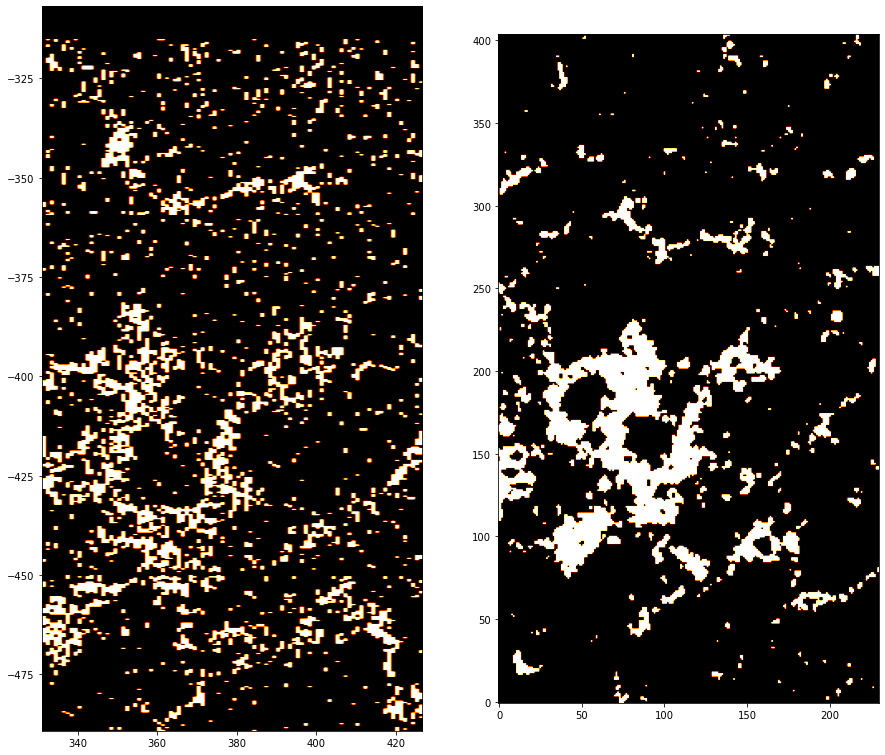

In [274]:
mgii = iris_raster.raster['Mg II k 2796'].data[:,:,28]
#mask = iris_raster.raster['Mg II k 2796']
#mgii = mgii[mask ==1]
extent_iris = extent_hx_hy
wiris = int(extent_iris[1]-extent_iris[0])+20
hiris = int(extent_iris[3]-extent_iris[2])+20
xc, yc = dim_aia[2]//2, dim_aia[1]//2
fig, ax = plt.subplots(1, 2, figsize=[15,15])
ax[0].imshow(mgii>68, extent=extent_iris, origin='lower', cmap='afmhot', interpolation=None)#, cmap=cm.sdoaia1600)
ax[1].imshow(img_data_list[0][dim_aia[0]-1,yc-hiris:yc+hiris, xc-wiris:xc+wiris,]>100, origin='lower', cmap = 'afmhot')
plt.show()

### Saving for alignment

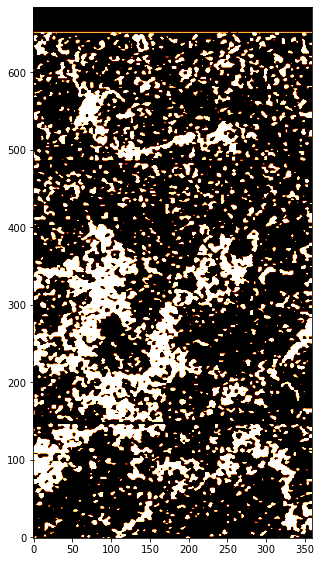

In [275]:
fig, ax = plt.subplots(1, 1, figsize=[5, 10])

ax.imshow(iris_img>60, origin="lower", cmap="afmhot")

#saveblank("iris_falign")

In [276]:
extent_iris = extent_hx_hy

wiris = int(extent_iris[1]-extent_iris[0])+20
hiris = int(extent_iris[3]-extent_iris[2])+20


def crop_image(img,tol=0):
    # img is 2D or 3D image data
    # tol  is tolerance
    mask = img>tol
    if img.ndim==3:
        mask = mask.all(2)
    m,n = mask.shape
    mask0,mask1 = mask.any(0),mask.any(1)
    col_start,col_end = mask0.argmax(),n-mask0[::-1].argmax()
    row_start,row_end = mask1.argmax(),m-mask1[::-1].argmax()
    return img[row_start:row_end,col_start:col_end]


cropped_mgii = crop_image(mgii, tol=0)

In [277]:
hiris, wiris

(202, 115)

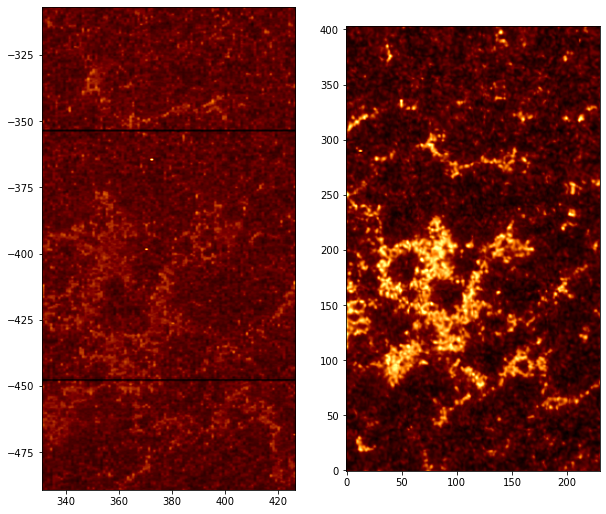

In [278]:
fig, ax = plt.subplots(1,2, figsize=[10, 10])
ax[0].imshow(cropped_mgii, extent=extent_iris, origin='lower', cmap='afmhot', interpolation=None)#, cmap=cm.sdoaia1600)
#saveblank('iris_to_align')
ax[1].imshow(img_data_list[0][dim_aia[0]-1,yc-hiris:yc+hiris, xc-wiris:xc+wiris,], origin='lower', cmap = 'afmhot')
plt.show()

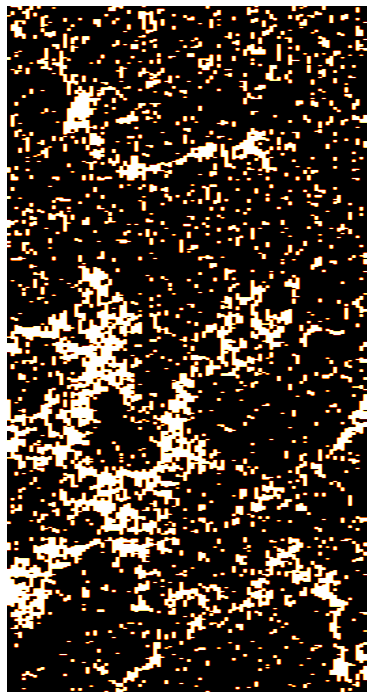

In [295]:
fig, ax = plt.subplots(1, 1, figsize=[5, 10])
#import mymask

def cond(data, threshold, blur_size=5, value=1, cond='>'):
    from scipy.ndimage import median_filter as blur
    if blur_size > 0:
        bdata = blur(data, size=blur_size)
    else:
        bdata=data
    if cond == '>': w = np.where(bdata > threshold)
    if cond == '>=': w = np.where(bdata >= threshold)
    if cond == '<': w = np.where(bdata < threshold)
    if cond == '<=': w = np.where(bdata <= threshold)
    if cond == '==': w = np.where(bdata == threshold)

    return make_mask(bdata, w, value=value)


def make_mask(data, w_cond, value=1):

    aux = data*0
    aux[w_cond] = value

    return aux

ax.imshow(cropped_mgii>63, extent=extent_iris, origin='lower', cmap='afmhot', interpolation=None)#, cmap=cm.sdoaia1600)
#ax.imshow(cond(mgii, 60, blur_size=3), extent=extent_iris, origin='lower', cmap='afmhot', interpolation=None)#, c
saveblank("iris_to_align")


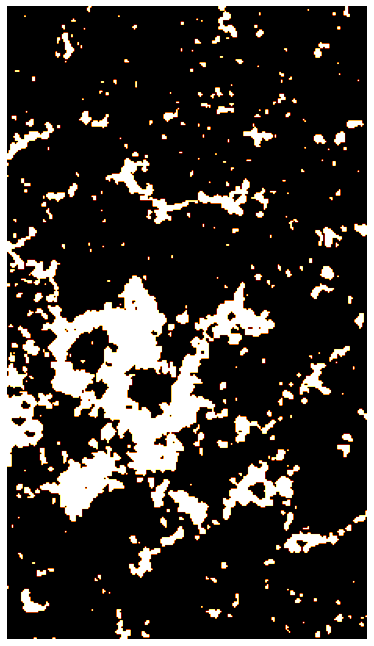

In [281]:
fig, ax = plt.subplots(1, 1, figsize=[5, 10])

ax.imshow(img_data_list[0][dim_aia[0]-1,yc-hiris:yc+hiris, xc-wiris:xc+wiris,]>90, origin='lower', cmap = 'afmhot')

saveblank("aia_to_align")

In [120]:
print(img_data_list[0].shape)
aux = img_data_list[0][dim_aia[0]-1,yc-hiris:yc+hiris, xc-wiris:xc+wiris,]
print(aux.shape)
from scipy import interpolate
import rebin
new_iris = rebin.congrid(mgii, [404, 230])

(568, 471, 608)
(129, 380)


In [173]:
import cv2

aia_aligned = cv2.imread("/Users/jkim/Desktop/mg2hk/output/aia_color.png")

#### Other frequencies

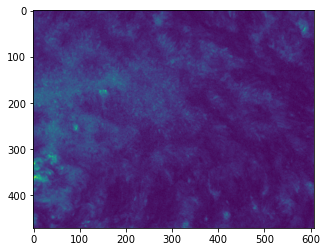

In [21]:
#304
plt.imshow(img_data_list[1][img_data_list[1].shape[0]-1,:,:])
#plt.savefig(outpath + '304.png')

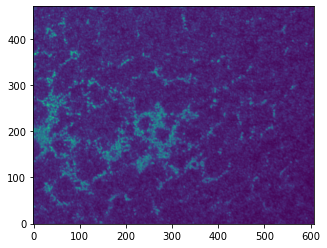

In [22]:
#1700
import numpy as np
plt.imshow(img_data_list[2][img_data_list[2].shape[0]-1,:,:], origin='lower')
#plt.savefig(outpath + '1700.png')

### Flickering

In [49]:
import numpy as np
aux = np.load('/Users/jkim/Downloads/iris_MgIIk_aia_1600_20220607_202829_3620106067_raster_t000_r00000.npz')
print(aux.files)
iii = aux['arr_0']
aaa = aux['arr_1']
del aux

['arr_0', 'arr_1']


In [81]:
aux = np.load('/Users/jkim/Downloads/iris_MgIIk_aia_1600_20220607_202829_3620106067_raster_t000_r00000.npz')
print(aux.files)
ii = aux['arr_0']
aa = aux['arr_1']

['arr_0', 'arr_1']


In [124]:
import matplotlib.pyplot as plt
from IPython import display


fig, ax = plt.subplots(1, 1, figsize=[10, 20])

for i in range(100):
    if (i%2 == 0):
        ax.imshow(aa, cmap="afmhot")
    else:
        ax.imshow(ii, vmin=0, vmax=150, cmap="afmhot")
    display.display(fig)
    display.clear_output(wait = True)
    plt.pause(.5)

KeyboardInterrupt: 

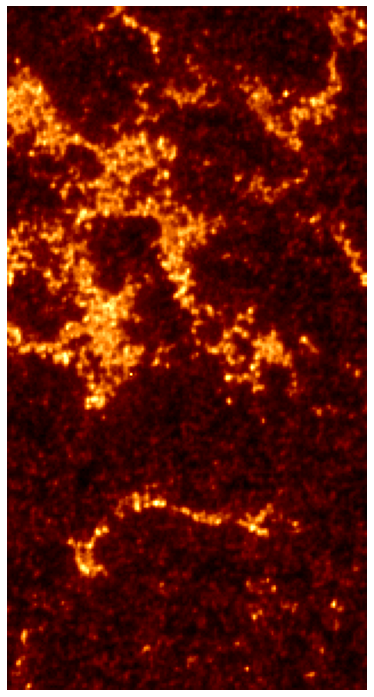

In [95]:
fig, ax = plt.subplots(1, 1, figsize=[5, 10])

ax.imshow(aaa, cmap = 'afmhot')

saveblank("aia_color_to_align")

In [112]:
from matplotlib.pyplot import figure, draw, pause
import matplotlib.image as mpimg
import rebin

aia_aligned_path = "/Users/jkim/Desktop/mg2hk/output/cut_aligned_colorf.png"
aligned = mpimg.imread(aia_aligned_path)

iiit = iii

In [117]:
import matplotlib.pyplot as plt
from IPython import display

iiit = crop_image(iiit, tol=0)
new_aligned = crop_image(aligned, tol=0)

fig, ax = plt.subplots(1, 1, figsize=[10, 20])

for i in range(100):
    if (i%2 == 0):
        ax.imshow(new_aligned, cmap="afmhot")
    else:
        ax.imshow(iiit, vmin=0, vmax=150, cmap="afmhot", interpolation=None)
    display.display(fig)
    display.clear_output(wait = True)
    plt.pause(.5)

KeyboardInterrupt: 

In [127]:
iiit.shape

(286, 158)

In [123]:
new_aligned.shape

(683, 360, 3)

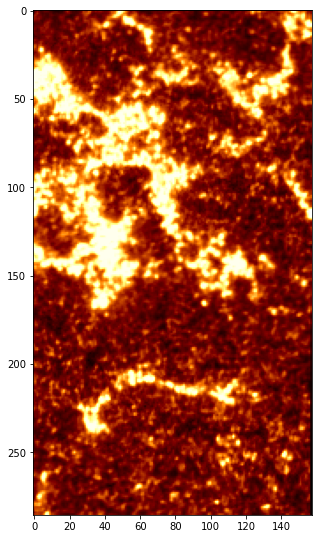

In [137]:
newest_aligned = new_aligned[:,:,0]
newest_aligned = rebin.congrid(newest_aligned, iiit.shape)
fig, ax = plt.subplots(1, 1, figsize=[5,10])
ax.imshow(newest_aligned, cmap='afmhot', interpolation = None)

In [138]:
newest_aligned.shape

(286, 158)

In [ ]:
## extent_hx_hy = [330.92126959698425, 426.6590563250996, -489.16880000000003, -306.8492]
extent_iris = extent_hx_hy
wiris = int(extent_iris[1]-extent_iris[0])*2
hiris = int(extent_iris[3]-extent_iris[2])*2
print(wiris, hiris)
print(mgii.shape)

print(aligned.shape)
print(iris_img.shape)

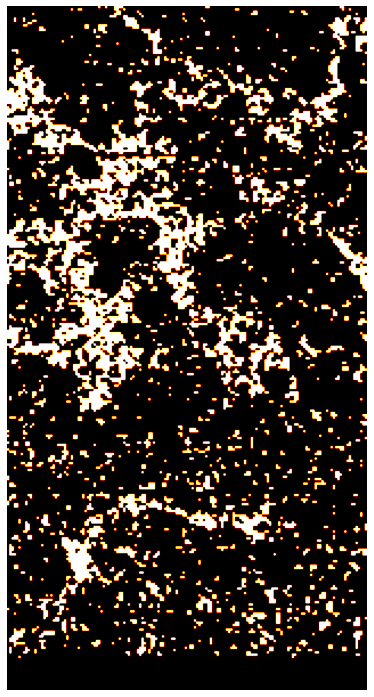

In [85]:
fig, ax = plt.subplots(1, 1, figsize=[5, 10])

ax.imshow(ii>63, cmap='afmhot', interpolation=None)#, cmap=cm.sdoaia1600)
#ax.imshow(cond(mgii, 60, blur_size=3), extent=extent_iris, origin='lower', cmap='afmhot', interpolation=None)#, c
saveblank("cut_iris_to_align")



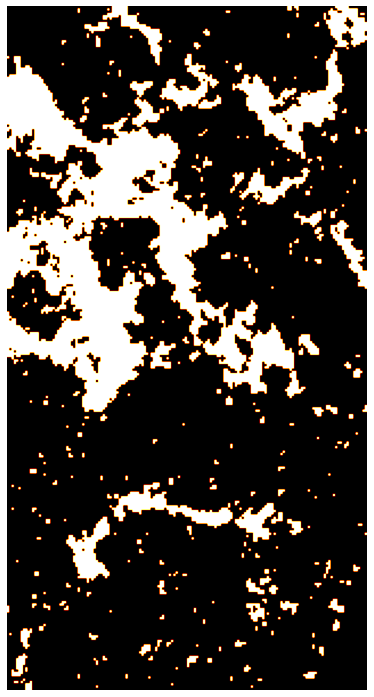

In [86]:
fig, ax = plt.subplots(1, 1, figsize=[5, 10])

ax.imshow(aa>90, cmap = 'afmhot')

saveblank("cut_aia_to_align")

### Next steps
Trying with different images + data
